# Goal of this notebook #

Apply the Gaussian mixture model for probabilistic clustering.

## Some introduction ##

The probabilistic clustering can be done by calculating the likelihood of each data point as

$$ P(x_i|\theta) = \sum_{c=1}^{C}P(x_i,t=c|\theta) \pi(c) \,, $$

where $\theta$ is the parameters of interest, $P(x_i,t=c|\theta)$ is the likelihood, $\pi(c)$ is the prior, and $C$ is the number of classes.

For the Gaussian mixture model, we assume that the likelihood of a particular class is Gaussian, then

$$ P(x_i,t=c|\theta_c) = {\mathcal N}(x_i|\mu_c,\Sigma_c) \,. $$

If $x_i$ has $d$ features, then $\mu_c$ is an $d$-dimensional vector parametrizing the mean of the distribution and $\Sigma_c$ is an $d\times d$ matrix parametrizing the covariance of the distribution.

We shall train the Gaussian mixture model using the "Expectation-Maximization" (EM) algorithm and infer the paramters $\theta$ ($\mu_c$ and $\Sigma_c$ for all classes) as well as the priors $\pi(c)$.

In [1]:
# load the required packages
import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal
import matplotlib.pyplot as pt
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
import time
from IPython import display

We first define the function that generates the data.

For simplicity and easy visualization, we set the likelihood to be a multivariate Gaussian distribution in 2-d space.

Therefore, the inputs of the data generating function are the number of data, the two vectors with 2 components for the mean ($\mu_1$ and $\mu_2$), and the two $2\times2$ matrices for the covariance ($\Sigma_1$ and $\Sigma_2$). We also set the random seeds so that the results are reproducable.

In [2]:
def generate_data(n_data1,n_data2,mu1,mu2,cov1,cov2,seed1=24,seed2=42):
    data1_true = multivariate_normal.rvs(mean=mu1_true,cov=cov1_true,size=n_data1, random_state=24)
    data2_true = multivariate_normal.rvs(mean=mu2_true,cov=cov2_true,size=n_data2, random_state=42)
    data = np.concatenate((data1_true,data2_true))

    return data1_true,data2_true,data

Let us now generate some random mean vectors and covariances.

Since the covariance needs to be semi-definite, we start by generating a non-negative variance vector with 2 components, and then generate a symmetric correlation matrix with the diagonal elements set to be unity and the off-diagonal elements set to be uniform random number between -1 and 1.

In the first trial, we set the number of the data to be the same. Once we generate data, we visualize them. The left panel displays the scatter plot of the true classes (red square and blue triangle) in 2-d space. The right panel displays the data point without classes, and this is the data that we will be working with.

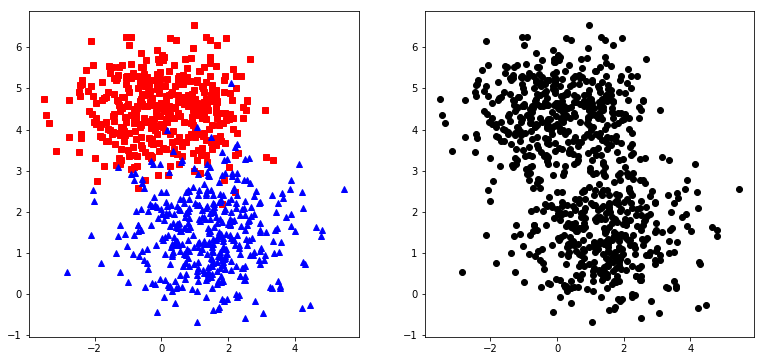

In [3]:
npr.seed(48)

mu1_true = npr.rand(2)*5
mu2_true = npr.rand(2)*5

var1_true = npr.rand(2)*2
var2_true = npr.rand(2)*2

corr1_true = np.array([[1,0],[0,1]])
corr2_true = np.array([[1,0],[0,1]])
corr1_true[0,1] = corr1_true[1,0] = 2*np.random.rand(1)-1
corr2_true[0,1] = corr2_true[1,0] = 2*np.random.rand(1)-1

cov1_true = corr1_true*np.sqrt(np.outer(var1_true,var1_true))
cov2_true = corr2_true*np.sqrt(np.outer(var2_true,var2_true))

n_data1 = n_data2 = 400
n_data = n_data1+n_data2

pi1_true = n_data1/n_data
pi2_true = n_data2/n_data

data1_true,data2_true,data = generate_data(n_data1,n_data2,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

# compute the logarithmic of the total likelihood P(x|theta) [including prior] using the true parameters
prob1_true = multivariate_normal.pdf(data,mean=mu1_true,cov=cov1_true)
prob2_true = multivariate_normal.pdf(data,mean=mu2_true,cov=cov2_true)
prob_true = pi1_true*prob1_true+pi2_true*prob2_true
lnprob_true = np.sum(np.log(prob_true))

Since we want to visualize the logarithmic likelihood (the color gradient of the raw likelihood does not have enough contrast for a clear visualization), we create meshes for $(x,y)$ between -4 and 8 with step size 0.5. We then compute the two logarithmic likelihoods using the true parameters (which are named as parameter_true).

In [4]:
# create 1-d x_plot and y_plot
x_plot = np.arange(-4,8,0.5)
y_plot = np.arange(-4,8,0.5)

# create the xy meshes from x_plot and y_plot
xx_plot, yy_plot = np.meshgrid(x_plot,y_plot)
xy_plot = np.stack((xx_plot,yy_plot),axis=-1)

# compute the logarithmic likelihood of the two Gaussian pdfs
# using the true parameters on xy meshes for visualization
lnprob1_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_true,cov=cov1_true)
lnprob2_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_true,cov=cov2_true)

## Expectation-Maximization algorithm ##

The EM algorithm is a coordinate descent optimization of variational lower bound

$$ \mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT \,, $$

where $T$ is the "latent variable" (in the Gaussian mixture model, $T$ is the classes), and $q(T)$ is the probability distribution of $T$ ($\int q(T) dT=1$). In the Gaussian mixture model, we can write the joint distribution for $N$ data points as

$$ \begin{eqnarray}
\log p(T, X \mid \theta)
&=& \sum\limits_{i=1}^N \log p(t_i, x_i \mid \theta)
= \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, {\mathcal N}(x_i \mid \mu_c, \Sigma_c)\right) \\
&=& \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \left[ \log \pi_c + \log {\mathcal N}(x_i \mid \mu_c, \Sigma_c)\right] \,. 
\end{eqnarray} $$

The EM algorithm maximizes $\mathcal{L}(\theta, q)$ by iteratively performing the so-called <b>E-step</b> and <b>M-step</b> until convergence. The EM algorithm is guranteed to improve for every step (so it is useful for debuggin) and converge to a <b>local</b> maximum, but not achieve the global maximum. Therefore, it is common to take a few random initialization (of $\theta$ and $\pi_c$) and report the best results.

### Implementation of the E-step ###

At the E-step, we fix $\theta$ (including $\pi_c$) and find $q(T)$ that maximizes $\mathcal{L}(\theta, q)$. One can show analytically that the result is given by

$$ q(T) = \max_{q} \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] = p(T|X, \theta) \,, $$

where $\mathcal{KL}$ is the KL divergence. In other words, we only need to set $q(T)=p(T|X, \theta)$ at the E-step.

In the Gaussian mixture model,

$$ \begin{eqnarray}
p(t_i=c|x_i,\theta)
&=& \frac{p(x_i|t_i=c,\theta)p(t_i=c|\theta)}{p(x_i|\theta)}
= \frac{p(x_i|t_i=c,\theta)p(t_i=c|\theta)}{\sum_{c=1}^C p(x_i|t_i=c,\theta)p(t_i=c|\theta)} \\
&=& \frac{{\mathcal N}(x_i|\mu_c,\Sigma_c)\pi_c}{\sum_{c=1}^C {\mathcal N}(x_i|\mu_c,\Sigma_c)\pi_c} \,.
\end{eqnarray} $$

In [5]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    q: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters

    q = np.zeros((N, C))
    for c in range(C):
        q[:,c] = multivariate_normal.pdf(x=X,mean=mu[c,:],cov=sigma[c,:,:])*pi[c]
    q = np.transpose(q.T/np.sum(q,axis=1))
    
    
    return q

### Implementation of the M-step ###

At the M-step, we fix $q(T)$, and find $\theta$ (including $\pi_c$) that maximizes ${\mathcal L}(\theta,q)$. Since now $q(T)$ is fixed, maximizing ${\mathcal L}(\theta,q)$ is equivalent to maximize $\mathop{\mathbb{E}}_{q(T)}[\log p(X,T|\theta)]$:

$$ \begin{eqnarray}
\max_{\theta} {\mathcal L}(\theta,q)
&=& \max_{\theta} \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT \\
&\equiv& \max_{\theta} \int q(T) \log p(X, T|\theta) dT
= \mathop{\mathbb{E}}_{q(T)}[\log p(X,T|\theta)] \,.
\end{eqnarray} $$

In the Gaussian mixture model, $p(X, T|\theta)$ has an analytical form and the derivatives with respect to $\mu_c$, $\theta_c$, and $\pi_c$ can all be done analytically. Specifically, let

$$ \begin{eqnarray}
M &=& \sum_{i=1}^N \sum_{c=1}^C q(t_i=c) \log[p(x_i|t_i=c,\theta)p(t_i=c|\theta)] \\
&=& \sum_{i=1}^N \sum_{c=1}^C q(t_i=c) [\log{\mathcal N}(x_i;\mu_c,\Sigma_c)+\log\pi_c ] \,.
\end{eqnarray}$$

To maximize $M$ with respect to $\mu_c$, $\Sigma_c$, and $\pi_c$, we set

$$ \frac{\partial M}{\partial \mu_c} = \frac{\partial M}{\partial \Sigma_c} = \frac{\partial M}{\partial \pi_c} =0 \,. $$

Using the [matrix derivatives](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf), we can compute

$$ \frac{\partial M}{\partial \mu_c} = \sum_{i=1}^N q(t_i=c) \Sigma_c^{-1}(x_i-\mu_c) \,, $$

$$ \begin{eqnarray}
\frac{\partial M}{\partial \Sigma_c}
&=& -\frac{1}{2} \sum_{i=1}^N q(t_i=c) \left[ \Sigma_c^{-1}-\Sigma_c^{-1}(x_i-\mu_c)(x_i-\mu_c)^T\Sigma_c^{-1}\right] \\
&=& -\frac{\Sigma_c^{-1}}{2} \sum_{i=1}^N q(t_i=c) \left[ I - (x_i-\mu_c)(x_i-\mu_c)^T\Sigma_c^{-1}\right] \,.
\end{eqnarray} $$

Let us first solve $\mu_c$. Since we want $\partial M/\partial\mu_c=0$ regardless of $\Sigma_c^{-1}$, we can compute $\mu_c$, which is independent of $i$, as

$$ \mu_c = \frac{\sum_{i=1}^N q(t_i=c)x_i}{\sum_{i=1}^N q(t_i=c)} \,. $$

This indicates that $\mu_c$ is essentially a weighted sum.

We next compute $\Sigma_c$. Setting $\partial M/\partial\Sigma_c=0$ and taking $\Sigma_c^{-1}$ outside of the summation, we have

$$ \Sigma_c^{-1} = \left[\sum_{i=1}^N q(t_i=c) I\right]\left[\sum_i q(t_i=c)(x_i-\mu_c)(x_i-\mu_c)^T\right]^{-1} \,, $$

or

$$ \Sigma_c = \left[\sum_{i=1}^N q(t_i=c)(x_i-\mu_c)(x_i-\mu_c)^T\right] \left[\sum_{i=1}^N q(t_i=c) I\right]^{-1} \,. $$
Note that $(x_i-\mu_c)(x_i-\mu_c)^T$ is a outer product so it produces a $d\times d$ matrix, which has the same dimension as $\Sigma_c$.

The derivative with respect to $\pi_c$ is trickier. Since $\pi_c$ is constrianed by $\sum_{c=1}^C\pi_c=1$, there are only $(C-1)$ degrees of freedom. To respect this constraint, we only consider $(C-1)$ free parameters from $\pi_1$ to $\pi_{C-1}$, and set

$$ \pi_C=1-\sum_{c=1}^{C-1}\pi_c \,. $$

Therefore,

$$ \begin{eqnarray}
M &=& \sum_{i=1}^N \Bigg\lbrace \sum_{c=1}^{C-1} q(t_i=c) [\log{\mathcal N}(x_i;\mu_c,\Sigma_c)+\log\pi_c ] + q(t_i=C) [\log{\mathcal N}(x_i;\mu_C,\Sigma_C)+\log\pi_C] \Bigg\rbrace \\
&=& \sum_{i=1}^N \Bigg\lbrace \sum_{c=1}^{C-1} q(t_i=c) \left[\log{\mathcal N}(x_i;\mu_c,\Sigma_c)+\log\pi_c \right] + q(t_i=C) \left[\log{\mathcal N}(x_i;\mu_C,\Sigma_C)+\log\left( 1- \sum_{c=1}^C\pi_c \right)\right] \Bigg\rbrace \,,
\end{eqnarray}$$

and so

$$ \frac{\partial M}{\partial \pi_c} = \sum_{i=1}^N \left[ \frac{q(t_i=c) }{\pi_c} - \frac{q(t_i=C)}{\pi_C} \right] \,. $$

Setting $\frac{\partial M}{\partial \pi_c}=0$, we obtain

$$ \sum_{i=1}^N \frac{q(t_i=c) }{\pi_c} = \sum_{i=1}^N \frac{q(t_i=C)}{\pi_C} $$

for all $c$. This must mean that

$$ \sum_{i=1}^N \frac{q(t_i=c) }{\pi_c} = {\rm constant} \,. $$

Therefore, we can first compute $\tilde{\pi}_c = \sum_{i=1}^N q(t_i=c)$, and then

$$ \pi_c = \frac{\tilde{\pi}_c}{\sum_c \tilde{\pi}_c} \,.$$

In [6]:
def M_step(X, q):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    q: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    C = q.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    mu = np.zeros((C,d))
    for c in range(C):
        mu[c,:] = np.sum((X.T)*q[:,c],axis=1)/np.sum(q[:,c])
        
    sigma = np.zeros((C,d,d))
    for c in range(C):
        diff = X-mu[c,:]
        sigma[c,:,:] = np.dot(np.sum(np.einsum('ij,ik->ijk',diff,diff).T*q[:,c],axis=-1),
                              np.eye(d)/np.sum(q[:,c]))
    
    pi = np.sum(q,axis=0)
    pi = pi/np.sum(pi)
    
    return pi, mu, sigma

### Convergence criterion ###

To track the convergence of the EM algorithm, we compute the loss function

$$ \begin{eqnarray}
\mathcal{L}(\theta, q) &=& \int q(T) \log\frac{p(X, T | \theta)}{q(T)}dT \\
&=& \sum_{i=1}^N \sum_{c=1}^C q(t_i =c) \left[\log \pi_c + \log \mathcal{N}(x_i | \mu_c, \Sigma_c) - \log q(t_i =c) \right] \,.
\end{eqnarray} $$

We will stop the iteration when $\mathcal{L}(\theta, q)$ saturates. Note that by construction the EM algorithm should <b>always</b> increase $\mathcal{L}(\theta, q)$. This serves as a good debugging tool.

In [7]:
def compute_vlb(X, pi, mu, sigma, q):
    """
    Each input is numpy array:
    X: (N x d), data points
    q: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    C = q.shape[1] # number of clusters

    loss = 0
    for c in range(C):
        loss = loss + np.sum(q[:,c]*(np.log(pi[c])+multivariate_normal.logpdf(x=X,mean=mu[c,:],cov=sigma[c,:,:])
                                    -np.log(q[:,c])))
    return loss

### Put everything together ###
Finally, let's put everything together in a training function. When we start a run, we randomly initialize the parameters ($\mu_c$, $\Sigma_c$, and $\pi_c$). At each iteration, we use the current ($\mu_c$, $\Sigma_c$, $\pi_c$) to estimate $q(T)$ by the <b>E-step</b>, and then use the estimated $q(T)$ to update ($\mu_c$, $\Sigma_c$, $\pi_c$) by the <b>M-step</b>. We then compute $\mathcal{L}(\theta,q)$, and stop the iteration if 

$$ \left|\frac{\mathcal{L}_j-\mathcal{L}_{j-1}}{\mathcal{L}_{j-1}}\right|\le \texttt{rtol} \,, $$

where $j$ is the iteration count. Since the EM algorithm can be sensitive to the random initialization, we perform the algorithm for multiple times (given by $\texttt{restarts}$) and report the best results.

In [8]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    
    best_pi = np.ones(C)/C
    best_mu = np.random.rand(C,d)
    best_sigma = np.zeros((C,d,d))
    for c in range(C):
        best_sigma[c,:,:] = np.eye(d)*np.random.rand(d)
        
    best_loss = -1e10

    for _ in range(restarts):
        try:
            # random initialization of the parameters
            last_loss = 0
            pi = np.ones(C)/C
            mu = np.random.rand(C,d)
            sigma = np.zeros((C,d,d))
            for c in range(C):
                sigma[c,:,:] = np.eye(d)*np.random.rand(d)
            
            # main loop
            for _ in range(max_iter):
                q = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, q)
                loss = compute_vlb(X, pi, mu, sigma, q)
                if np.abs((loss-last_loss)/last_loss)<=rtol:
                    break
                last_loss = loss+0

            # record the best result
            if loss>best_loss:
                best_loss = loss
                best_pi = pi
                best_mu = mu
                best_sigma = sigma

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


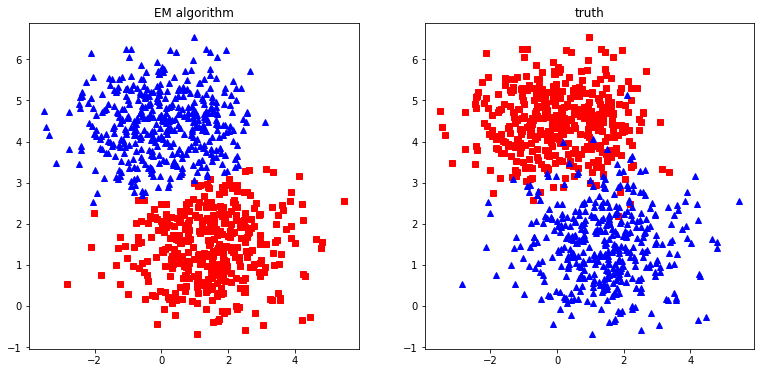

In [9]:
best_loss, best_pi, best_mu, best_sigma = train_EM(data, 2, rtol=1e-4, max_iter=1000, restarts=20)

prob = np.zeros((n_data,2))
for c in range(2):
    prob[:,c] = multivariate_normal.pdf(x=data,mean=best_mu[c,:],cov=best_sigma[c,:,:])*best_pi[c]

cond = prob[:,0]>prob[:,1]
data1_EM = data[cond,:]
data2_EM = data[~cond,:]

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.title('EM algorithm')
pt.plot(data1_EM[:,0],data1_EM[:,1],'rs')
pt.plot(data2_EM[:,0],data2_EM[:,1],'b^')
pt.subplot(1,2,2)
pt.title('truth')
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.show()

print()

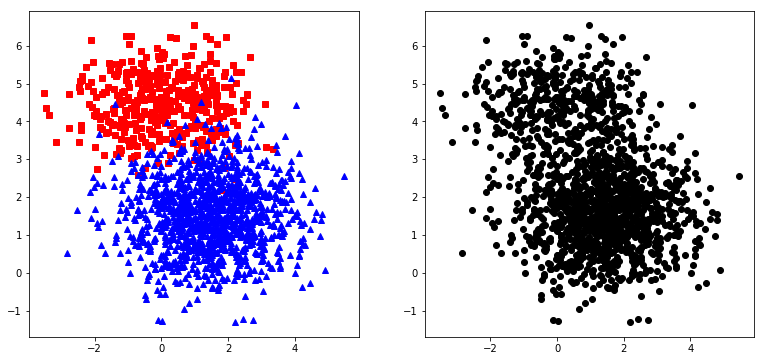

In [10]:
npr.seed(48)

mu1_true = npr.rand(2)*5
mu2_true = npr.rand(2)*5

var1_true = npr.rand(2)*2
var2_true = npr.rand(2)*2

corr1_true = np.array([[1,0],[0,1]])
corr2_true = np.array([[1,0],[0,1]])
corr1_true[0,1] = corr1_true[1,0] = 2*np.random.rand(1)-1
corr2_true[0,1] = corr2_true[1,0] = 2*np.random.rand(1)-1

cov1_true = corr1_true*np.sqrt(np.outer(var1_true,var1_true))
cov2_true = corr2_true*np.sqrt(np.outer(var2_true,var2_true))

n_data1 = 400
n_data2 = 1200
n_data = n_data1+n_data2

pi1_true = n_data1/n_data
pi2_true = n_data2/n_data

data1_true,data2_true,data = generate_data(n_data1,n_data2,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

# compute the logarithmic of the total likelihood P(x|theta) [including prior] using the true parameters
prob1_true = multivariate_normal.pdf(data,mean=mu1_true,cov=cov1_true)
prob2_true = multivariate_normal.pdf(data,mean=mu2_true,cov=cov2_true)
prob_true = pi1_true*prob1_true+pi2_true*prob2_true
lnprob_true = np.sum(np.log(prob_true))

/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/gpfs01/astro/workarea/cchiang/system/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


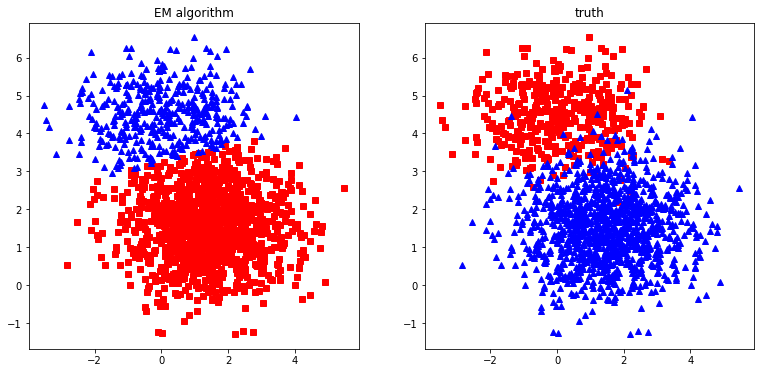

In [11]:
best_loss, best_pi, best_mu, best_sigma = train_EM(data, 2, rtol=1e-4, max_iter=1000, restarts=20)

prob = np.zeros((n_data,2))
for c in range(2):
    prob[:,c] = multivariate_normal.pdf(x=data,mean=best_mu[c,:],cov=best_sigma[c,:,:])*best_pi[c]

classes = np.argmax(prob,axis=1)
data1_EM = data[classes==0,:]
data2_EM = data[classes==1,:]

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.title('EM algorithm')
pt.plot(data1_EM[:,0],data1_EM[:,1],'rs')
pt.plot(data2_EM[:,0],data2_EM[:,1],'b^')
pt.subplot(1,2,2)
pt.title('truth')
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.show()